
# Preparation
We need to install the huggingface's library called `transformers` and its dependencies

In [1]:
%%bash
pip install tqdm boto3 requests regex sentencepiece sacremoses

  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=0b8c7de45030a273b339f88721816aec0061b09e8e07c1edf9934f7852c6cb91
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
!pip install transformers

     |████████████████████████████████| 778kB 4.5MB/s 
     |████████████████████████████████| 3.0MB 13.0MB/s 


In [3]:
import torch
from transformers import BertTokenizerFast
from transformers import DistilBertForTokenClassification, BertForTokenClassification

from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import torch.nn.functional as F
import torch.nn as nn

import requests
from xml.dom import minidom

In [4]:
# Store the model we want to use
MODEL_NAME = "bert-base-uncased"

# We need to create the model and tokenizer
bert_model = BertForTokenClassification.from_pretrained(MODEL_NAME)
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

In [5]:
review_train_data = 'https://raw.githubusercontent.com/HSLCY/ABSA-BERT-pair/master/data/semeval2014/Restaurants_Train.xml'
r = requests.get(review_train_data)
open('train.xml', 'wb').write(r.content)

1236939

now we need to extract all the relevant data from the xml sentences

In [6]:
xml_doc = minidom.parse('train.xml')
sentences_xml = xml_doc.getElementsByTagName('sentence')

sentences = dict()
aspect_terms = dict()

for d in sentences_xml:
  doc_id  = d.getAttribute('id')
  doc_text = d.getElementsByTagName('text')[0].firstChild.nodeValue
  sentences[doc_id] = doc_text

  for aspect_term in d.getElementsByTagName('aspectTerm'):
    if doc_id not in aspect_terms:
      aspect_terms[doc_id] = list()

    term = aspect_term.getAttribute('term')
    sentiment = aspect_term.getAttribute('polarity')
    from_idx = aspect_term.getAttribute('from')
    to_idx = aspect_term.getAttribute('to')

    aspect_terms[doc_id].append((term, sentiment, from_idx, to_idx))


In [7]:
sample_doc_id = "2818"
sample_sentence = sentences[sample_doc_id]
print(sample_sentence)
print(aspect_terms[sample_doc_id])

This was my frist time at Cafe St. Bart's and I must say how delicous the food and the service was.
[('food', 'positive', '74', '78'), ('service', 'positive', '87', '94')]


# Preprocessing 

In [8]:
label_vocab = {
    'O': 0,
    'B-ASPECT-POS': 1,
    'I-ASPECT-POS': 2,
    'B-ASPECT-NEG': 3,
    'I-ASPECT-NEG': 4,
    'B-ASPECT-NEU': 5,
    'I-ASPECT-NEU': 6,
}

def get_labels(tokenized_sentence, aspect_terms, label_vocab=label_vocab):
  """
  Returns
  ---
  dict with format:
    {
      result_ids: [],
      result_tags: []
    }
  """
  list_aspect_term = list(aspect_terms)
  i = 0
  j = 0
  tokenized_sentence_ids = tokenized_sentence['input_ids']
  if torch.is_tensor(tokenized_sentence_ids):
    tokenized_sentence_ids = tokenized_sentence_ids.squeeze(0)
  
  tokenized_sentence_offset_mapping = tokenized_sentence['offset_mapping']
  if torch.is_tensor(tokenized_sentence_offset_mapping):
    tokenized_sentence_offset_mapping = tokenized_sentence_offset_mapping.squeeze(0)

  result = dict(
      result_ids=list(),
      result_tags=list()
  )
  aspect_term = list_aspect_term[i]
  is_begin_aspect = True
  for j in range(len(tokenized_sentence_ids)):
    offset_start, offset_end = tokenized_sentence_offset_mapping[j]

    if j > 0 and j < len(tokenized_sentence_ids) and is_intersect_with(aspect_term, offset_start, offset_end):
      polarity = get_polarity(aspect_term)
      if is_begin_aspect:
        result['result_ids'].append(label_vocab['B-ASPECT-' + polarity])
        result['result_tags'].append('B-ASPECT-' + polarity)
        is_begin_aspect = False
      else:
        result['result_ids'].append(label_vocab['I-ASPECT-' + polarity])
        result['result_tags'].append('I-ASPECT-' + polarity)
      
      if i <= len(list_aspect_term) and should_go_to_next_aspect(aspect_term, offset_start, offset_end):
        is_begin_aspect = True
        i += 1
    else:
      result['result_ids'].append(label_vocab['O'])
      result['result_tags'].append('O')

  return result

def is_intersect_with(aspect_term, offset_start, offset_end):
  """
  utility function to determine if the offset has intersected
  """
  aspect_start_idx = int(aspect_term[2])
  aspect_end_idx = int(aspect_term[3])

  return offset_start >= aspect_start_idx and offset_end <= aspect_end_idx

def should_go_to_next_aspect(aspect_term, offset_start, offset_end):
  aspect_start_idx = int(aspect_term[2])
  aspect_end_idx = int(aspect_term[3])

  return offset_end > aspect_end_idx

def get_polarity(aspect_term):
  """
  change polarity from `positive` or `negative` into `POS` `NEG` or `NEU`
  """
  polarity = aspect_term[1]
  if polarity == 'positive':
    return 'POS'

  if polarity == 'negative':
    return 'NEG'

  return 'NEU'

def get_default_label(tokenized_sentence, label_vocab=label_vocab):
  tokenized_sentence_ids = tokenized_sentence['input_ids']
  if torch.is_tensor(tokenized_sentence_ids):
    tokenized_sentence_ids = tokenized_sentence_ids.squeeze(0)

  return dict(
      result_ids=[label_vocab['O'] for _ in range(len(tokenized_sentence_ids))],
      result_tags=['O' for _ in range(len(tokenized_sentence_ids))]
  )

In [9]:
inputs = list()
labels = list()
for sid in sentences:
  tokenized = tokenizer(sentences[sid], return_offsets_mapping=True)
  inputs.append(tokenized)
  
  label_sequence = get_default_label(tokenized)

  if sid in aspect_terms:
    aspect_term = aspect_terms[sid]
    label_sequence = get_labels(tokenized, aspect_term) 
  labels.append(label_sequence)

In [10]:
sample_input_tensor = torch.tensor(inputs[0]['input_ids'])
sample_output_tensor = bert_model(sample_input_tensor.reshape(1, -1))
print(sample_output_tensor[0].shape)
print(sample_input_tensor.shape)


torch.Size([1, 11, 2])
torch.Size([11])


In [11]:
class AspectTermClassificationModel(nn.Module):
  def __init__(self, bert_for_tok_classification, label_vocab: dict):
    super().__init__()
    self.real_model = bert_for_tok_classification
    prev_classifier = self.real_model.classifier
    self.real_model.classifier = nn.Linear(prev_classifier.in_features, len(label_vocab))
  
  def forward(self, X: torch.Tensor):
    return self.real_model(X)


before training, we should split between train and test data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(inputs, labels)

binarizer = LabelBinarizer()
binarizer.fit(list(label_vocab.values()))

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
model = AspectTermClassificationModel(bert_model, label_vocab).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCELoss()

We need to freeze BERT layer and will fine tune the `classifier` layer


In [15]:
for model_param in model.parameters():
  model_param.requires_grad = False

for model_param in model.real_model.classifier.parameters():
  model_param.requires_grad = True

# Training the Model

In [16]:
import numpy as np

epochs = 10

losses = list()
for epoch in range(epochs):
  epoch_losses = list()

  for x, y in tqdm(zip(X_train, y_train)):
    optimizer.zero_grad()

    logits = model(torch.tensor(x['input_ids']).to(device).reshape(1, -1))[0]
    loss = criterion(F.softmax(logits.squeeze(0), dim=1), 
                     torch.tensor(binarizer.transform(y['result_ids'])).float().to(device))
    
    epoch_losses.append(loss.item())
    loss.backward()
    optimizer.step()

  losses.append(np.mean(epoch_losses))


2283it [00:27, 83.24it/s]
2283it [00:27, 83.49it/s]
2283it [00:27, 84.09it/s]
2283it [00:27, 83.58it/s]
2283it [00:27, 84.09it/s]
2283it [00:27, 84.36it/s]
2283it [00:26, 85.00it/s]
2283it [00:26, 85.81it/s]
2283it [00:26, 84.76it/s]
2283it [00:26, 84.73it/s]


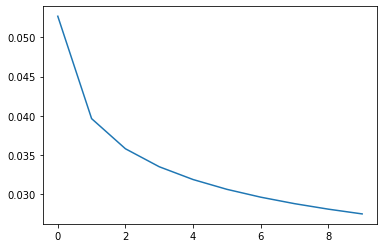

In [17]:
plt.plot(np.arange(epochs), losses)

In [18]:
def predict(model, x):
  with torch.no_grad():
    logits = model(torch.tensor(x['input_ids']).to(device).reshape(1, -1))[0]
    return torch.argmax(F.softmax(logits, dim=2), dim=2)

In [19]:
y_tensor = torch.tensor(y['result_ids']).to(device)
y_pred = predict(model, x).squeeze(0)
torch.sum( y_pred == y_tensor).double().div(y_tensor.shape[0])


tensor(0.9688, device='cuda:0', dtype=torch.float64)

In [21]:
inverse_label_vocab = {v: k for k, v in label_vocab.items()}

def calculate_metrics(y_trues:list, y_preds:list, label_vocab: dict=label_vocab):
  inverse_vocab = {v: k for k, v in label_vocab.items()}
  metrics = {k: dict(correct=0, missed=0) for k in inverse_vocab}

  for y_true, y_pred in zip(y_trues, y_preds):
    for tok_true, tok_pred in zip(y_true, y_pred):
      if tok_true == tok_pred:
        metrics[tok_true]['correct'] += 1
      else:
        metrics[tok_true]['missed'] +=  1

  return metrics

def print_metrics(metrics, inverse_label_vocab: dict=inverse_label_vocab):
  for m in metrics:
    n_correct = metrics[m]['correct']
    n_missed = metrics[m]['missed']
    print('acc of {} = {:.1%}, correct: {}, missed: {}'.format(inverse_label_vocab[m], n_correct / float(n_correct + n_missed), n_correct, n_missed ))

In [22]:
y_preds = list()
y_trues = list()

for x, y in tqdm(zip(X_train, y_train)):
  y_pred = predict(model, x).squeeze(0).cpu().numpy()
  y_preds.append(y_pred)
  y_trues.append(y['result_ids'])
  
metrics = calculate_metrics(y_trues, y_preds)
print_metrics(metrics)

acc of O = 99.4%, correct: 40531, missed: 263
acc of B-ASPECT-POS = 69.0%, correct: 626, missed: 281
acc of I-ASPECT-POS = 62.1%, correct: 512, missed: 313
acc of B-ASPECT-NEG = 39.8%, correct: 132, missed: 200
acc of I-ASPECT-NEG = 38.3%, correct: 64, missed: 103
acc of B-ASPECT-NEU = 30.3%, correct: 91, missed: 209
acc of I-ASPECT-NEU = 24.1%, correct: 51, missed: 161


In [24]:
for x, y in tqdm(zip(X_test, y_test)):
  y_pred = predict(model, x).squeeze(0).cpu().numpy()
  y_preds.append(y_pred)
  y_trues.append(y['result_ids'])

metrics = calculate_metrics(y_trues, y_preds)
print_metrics(metrics)

761it [00:08, 94.86it/s]


acc of O = 99.0%, correct: 66791, missed: 663
acc of B-ASPECT-POS = 66.3%, correct: 1008, missed: 513
acc of I-ASPECT-POS = 54.1%, correct: 726, missed: 615
acc of B-ASPECT-NEG = 34.7%, correct: 188, missed: 354
acc of I-ASPECT-NEG = 24.6%, correct: 78, missed: 239
acc of B-ASPECT-NEU = 25.0%, correct: 111, missed: 333
acc of I-ASPECT-NEU = 16.4%, correct: 53, missed: 271


# Saving the model In Google Drive

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144465 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.22-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [ ]:
!ls drive | grep app

In [ ]:
torch.save(model.state_dict(), 'drive/absa.pth')